Balandis, Alina

Gelabert Gómez, Martí

# Imports

In [1]:
# imports
import sklearn
import numpy as np
import pandas as pd
from sklearn.datasets import *
import matplotlib.pyplot as plt
import math
import seaborn as sns

# Normalization
from sklearn.preprocessing import MinMaxScaler

# Functions

In [2]:
# Normalization of your data
# now everything will be set in a range of 0 to 1
def splitLastColumn(x):
  """ Returns two numpy vector corresponding to x and y. Splits last columns, and y is transformed to column to row shape.
      [x1,x2,x3,x4,y] -> [x1,x2,x3,x4] [y]    
  """
  # the [:end] will not take the end number position in count
  end = x.shape[1]-1
  y = x[:,end:]
  return (np.array(x[:,:end]),np.array(y).flatten())

def normalize_data(x):
    """ Appling minmax normalization on the y axis sample = [x1,x2,x3,x4]"""
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(x)
    return data_scaled, scaler

# each row represents one feature from all samples in order
def reshape_feature(x):
  values = []
  for feature in range(x.shape[1]):
    f = []
    for i in range(x.shape[0]):
      f.append(x[i][feature])
    values.append(f)
  return np.array(values)

# Generate an arrays with a 3 element list for each k partition
# with the values of a triangular shape functions like
# [begining, peak value, ending] 
def k_partitions(k: int, min: int, max: int) -> np.ndarray:
  """  Generate an arrays with a 3 element list for each k partition with the values of a triangular shape functions like
       [begining, peak value, ending] points """
  spaces = []
  portion = (max-min)/(k-1)
  counter = 0
  for i in range(k):
    if(i==0): # first triangle is just half of it
      spaces.append([min,min, min + portion])
      counter = min + portion
    else:
      if(i==(k-1)): # last triangle is just half of it
        spaces.append([max-portion,max, max])
      else: # General cases
        spaces.append([counter-portion,counter,counter+portion])
        counter=counter+portion
  return np.array(spaces)


def mu(x,j,k) -> np.ndarray:
    a = (j - 1)/(k-1)
    b = 1/(k-1)
    value = 1 - abs(x-a)/b
    if value <=0:
        return 0
    else:
        return value

# For each feature you will have a k lenght vector with the 
# membership degree of that place.
def membership_for_all_features(x: np.ndarray, k:np.ndarray):
  """For each feature you will have a k lenght vector with the membership degree of that place."""
  output = []
  n_features = len(k)
  for sample in range(len(x)):
    membership_i = []
    # for every feature in the sample
    i = 0
    for f in range(n_features):
      tmp=[]
      # for every subspace of that feature
      for j in range(k[i]):
        if n_features == 1:
          tmp.append(mu(x[sample],j+1,k[i]))
        else:
          tmp.append(mu(x[sample][f],j+1,k[i]))
      # check for the next k_i
      i+=1
      membership_i.append(tmp)
    # when you finish to append you will get the membership of every characteristic of that sample  
    output.append(membership_i)
  return output

#####IMPORTANT CHANGE THIS TO BE DINAMIC
# Here we just generate all posible combinations for all the feature k_i
def combinations_for_k(k:np.ndarray):
  """ Here we just generate all posible combinations for all the feature k_i 
      for example k = [2,2] will return
      [[1,1],[1,2],[2,1],[2,2]]
  """
  output = []
  labels = len(k)
  ### Change this
  if len(k)==3:
    for j in range(k[0]):
      for r in range(k[1]):
        for m in range(k[2]):
          output.append([j,r,m])
    return output
  if len(k)==2:
    for j in range(k[0]):
      for r in range(k[1]):
        output.append([j,r])
    return output
  else:
    for j in range(k[0]):
      output.append([j])
    return output

# now we need to compute every degree of compatibility with every combination
# we will have k_1*k2*...K_n diferent combinations
# if one sample is provided use [[0,3  0,2  0,3]]
def degree_of_compatibility(membership_values, combinations):
  output = []
  n_features = len(combinations[0])
  n_samples = len(membership_values)

  for i in range(n_samples):
    general = []
    for c in combinations:
      tmp = []
      for j in range(n_features):
        if len(membership_values[i])==1:
            tmp.append(membership_values[i][0][c[j]])
        else:
            tmp.append(membership_values[i][j][c[j]])
      tmp=np.array(tmp)
      general.append(np.product(tmp))
    output.append(general)
  return output

# calculating all combinations for W
def Wj1_jn(dc,k:np.ndarray, alpha=1):
    return np.power(dc,alpha)

# Now we need to compute bj1..jn, we will get a vector with the number of combinations
# posible
def bj1_jn(w, y_real):
  output = []
  n_samples=len(w)
  for j in range(len(w[0])):# these are the number of combinations we have
    numerator = [] 
    denominator = []
    for i in range(n_samples):
      numerator.append(w[i][j]*y_real[i])
      denominator.append(w[i][j])
    numerator=np.array(numerator)
    denominator=np.array(denominator)
    b_calculation = np.sum(numerator)/np.sum(denominator)

    output.append(b_calculation)
  return output

#y(x_p)
# First version of prediction
def prediction(dc,b,w):
    output = []
    n_samples=len(w)
  
    # change samples
    for i in range(n_samples):
        numerator = [] 
        denominator = []

        for j in range(len(w[0])):# these are the number of combinations we have
            numerator.append(dc[i][j]*b[j])
            denominator.append(dc[i][j])

        numerator=np.array(numerator)
        denominator=np.array(denominator)
        #print(denominator)
        value = np.sum(numerator)/np.sum(denominator)
        output.append(value)
    return output


# This method allows to predict the values with the method shown in the section 4 of the papers
# Here we will be using the two tables
def predictV2(x,b:np.ndarray, B:np.ndarray,k:np.ndarray):
    
    membership_values = membership_for_all_features(b,B)

    membership_values_x = membership_for_all_features(x,k)
    combinations = combinations_for_k(k)

    # U_ji...jn
    dc = degree_of_compatibility(membership_values_x, combinations)
    
    # this tables only will contain the linguistic labels
    first_table = np.zeros((k[0],k[1]))
    second_table = np.zeros((k[0],k[1]))
    
    # this will contain the raw membership functions values 
    raw_first = np.zeros((k[0],k[1]))
    raw_second = np.zeros((k[0],k[1]))
    
    output_table = np.zeros((k[0],k[1]))
    
    space = k_partitions(B[0], 0, 1)
    
   
    for i in range(len(combinations)):
        
        first_table[combinations[i][0]][combinations[i][1]]= np.argmax(membership_values[i])
        raw_first[combinations[i][0]][combinations[i][1]] = membership_values[i][0][np.argmax(membership_values[i])]

        
    for i in range(len(combinations)):    
        #####
        tmp = membership_values[i][0]
        tmp[np.argmax(membership_values[i])]=-42 # Giving a low value to find the second
        second_table[combinations[i][0]][combinations[i][1]]= np.argmax(tmp)
        
        raw_second[combinations[i][0]][combinations[i][1]]= membership_values[i][0][np.argmax(tmp)]
        
    prediction = []
    for sample in range(len(x)):
        numerator = 0
        denominator = 0
        for i in range(len(combinations)):
            # What is B**
            
            # Getting the first and the second membership space for the b fuzzy
            # in Bx[1] we will find the peak values
            B1 = space[int(first_table[combinations[i][0]][combinations[i][1]])]
            B2 = space[int(second_table[combinations[i][0]][combinations[i][1]])]
            
            numerator   += dc[sample][i]*B1[1]*raw_first[combinations[i][0]][combinations[i][1]] + dc[sample][i]*B2[1]*raw_second[combinations[i][0]][combinations[i][1]]
            denominator += dc[sample][i]*raw_first[combinations[i][0]][combinations[i][1]] + dc[sample][i]*raw_second[combinations[i][0]][combinations[i][1]]
        
        prediction.append(numerator/denominator)
   
    return prediction, first_table, second_table



def execute(x,y,k=np.array([5,5]), alpha = 5, v=0, B=np.array([5])):

  membership_values = membership_for_all_features(x,k)

  # this will be the subspaces we will check on each value space
  combinations = combinations_for_k(k)
  dc = degree_of_compatibility(membership_values, combinations)
    
  w = Wj1_jn(dc,k,alpha)

  b = bj1_jn(w,y)  
    
  if v==0:
      y_p = prediction(dc,b,w)
  else: 
      if v == 1:
        y_p,_,_ = predictV2(x, b, B, k)
      else:
        print("Predict with method from section 3")
        y_p = prediction(dc,b,w)
    
  PI = []
  for i in range(len(y)):
    a = (y_p[i]-y[i])**2
    PI.append(a/2)
    # print(f'predicted {y_p[i]} - real {y[i]}')
  PI=np.array(PI)
  #print("K = ",k," alpha = ",alpha," accuracy = ", np.sum(PI) )
  return np.sum(PI),y_p,b


# use v=0 to use the section 3 version
# use v=1 to use the section 4 version
def execute_test(x,y,ks= [[2,2],[3,3],[4,4],[5,5]], alphas = [0.1,0.5,1,5,10,50,100], B=[5], v=1):
    """This method will execute a secuence of tests for evaluation"""
    print("Prediction with section ", v+3 , " method")
    general = []
    for alpha in alphas:
      row = [alpha]
      for k in ks:
        a,out,_ = execute(x,y,np.array(k),alpha,v,B)
        row.append(a)
      general.append(row)

    # Create the pandas DataFrame
    df = pd.DataFrame(general, columns=['alpha', 'K = 2','K = 3','K = 4','K = 5'])
    # print dataframe.
    return df

# the data should be already normalized, and it should be used this execution for normal
# testing
def simple_predictionV2(x,y,K:np.ndarray,B:np.ndarray, alpha = 1.0):
    
    membership_values = membership_for_all_features(x,K)
    c = combinations_for_k(K)

    # U_ji...jn
    dc = degree_of_compatibility(membership_values, c)
    w = Wj1_jn(dc,K,alpha)
    b = bj1_jn(w,y)  

    predictions, first, second = predictV2(x,b, B,K)
    print("PI = ", np.sum(np.power(np.subtract(predictions,y),2))/2)

    bs = np.zeros_like(first)
    
    for i in range(len(c)):
      bs[c[i][0]][c[i][1]] = b[i]

    return predictions, first, second, bs



In [3]:
# Visualization
def view_matrix(data, title):
    data = np.array(data)

    # The transpose is just for data visualization
    cp = data.transpose()


    ax = sns.heatmap(cp, annot=True, cbar=None, xticklabels=True, yticklabels=True)
    ax.invert_yaxis() 
    plt.title(title,fontsize=12)

    #plt.savefig("visualize_numpy_array_03.png", bbox_inches='tight', dpi=100, )

    plt.show()

def rules(matrix):
    t = ['S','MS','M','ML','L']
    
    a=0
    for i in range(len(matrix)):

        for j in range(len(matrix[0])):
            print("Rule_",a," IF x1 = ",t[i]," AND x2 =", t[j]," THEN ", t[int(matrix[i][j])])
            a+=1

# Execution Playground

Prediction with section  4  method
   alpha     K = 2     K = 3     K = 4     K = 5
0    0.1  1.807837  0.469818  0.209347  0.114915
1    0.5  1.221603  0.310282  0.129857  0.055851
2    1.0  0.845653  0.206260  0.080668  0.033214
3    5.0  0.279654  0.070386  0.034614  0.021762
4   10.0  0.241999  0.066506  0.038014  0.024087
5   50.0  0.253302  0.081356  0.049043  0.027729
6  100.0  0.262145  0.084890  0.052636  0.028507 


Prediction with k =  [5, 5]  B =  [5]  alpha =  5
PI =  0.02176193122936275
 Predictions : 

[0.4401871092969472, 0.9553117547771284, 0.19086108523859008, 0.6518655533738433, 0.8027897468613021, 0.5791277924276599, 0.831605729185972, 0.025060637179291613, 0.6775394224738807, 0.415973895393727, 0.36329338599993594, 0.3915194189851584, 0.3952129744251424, 0.38915050298414133, 0.7545899825872177, 0.6447731928361851, 0.6541424226680246, 0.8156424347198206, 0.7974030413248757, 0.09913326037441289, 0.9618000746257875, 0.8421071964214829, 0.6435892149592258, 0.7080053180

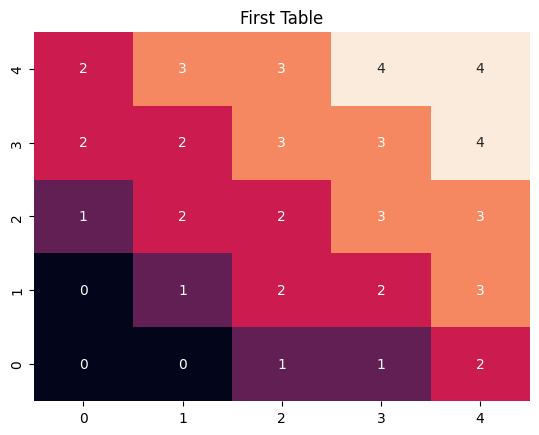

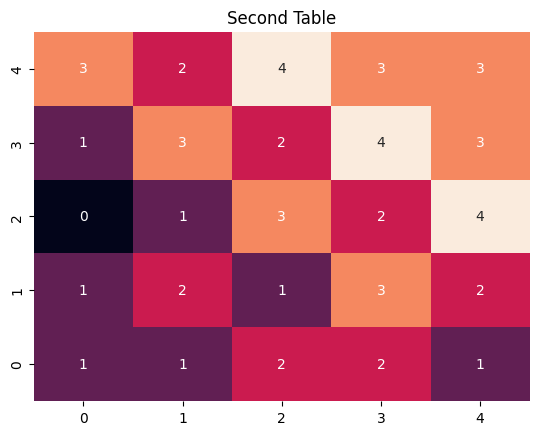

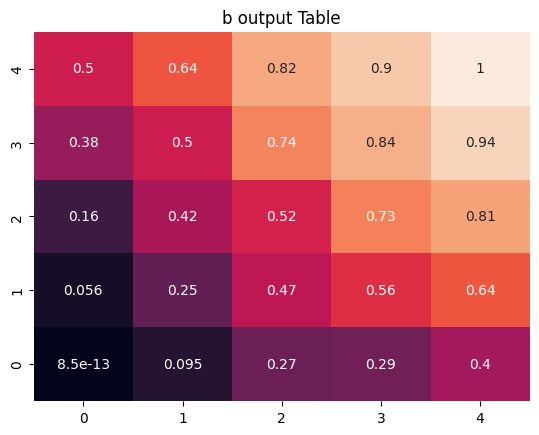

Rules Main Table
Rule_ 0  IF x1 =  S  AND x2 = S  THEN  S
Rule_ 1  IF x1 =  S  AND x2 = MS  THEN  S
Rule_ 2  IF x1 =  S  AND x2 = M  THEN  MS
Rule_ 3  IF x1 =  S  AND x2 = ML  THEN  M
Rule_ 4  IF x1 =  S  AND x2 = L  THEN  M
Rule_ 5  IF x1 =  MS  AND x2 = S  THEN  S
Rule_ 6  IF x1 =  MS  AND x2 = MS  THEN  MS
Rule_ 7  IF x1 =  MS  AND x2 = M  THEN  M
Rule_ 8  IF x1 =  MS  AND x2 = ML  THEN  M
Rule_ 9  IF x1 =  MS  AND x2 = L  THEN  ML
Rule_ 10  IF x1 =  M  AND x2 = S  THEN  MS
Rule_ 11  IF x1 =  M  AND x2 = MS  THEN  M
Rule_ 12  IF x1 =  M  AND x2 = M  THEN  M
Rule_ 13  IF x1 =  M  AND x2 = ML  THEN  ML
Rule_ 14  IF x1 =  M  AND x2 = L  THEN  ML
Rule_ 15  IF x1 =  ML  AND x2 = S  THEN  MS
Rule_ 16  IF x1 =  ML  AND x2 = MS  THEN  M
Rule_ 17  IF x1 =  ML  AND x2 = M  THEN  ML
Rule_ 18  IF x1 =  ML  AND x2 = ML  THEN  ML
Rule_ 19  IF x1 =  ML  AND x2 = L  THEN  L
Rule_ 20  IF x1 =  L  AND x2 = S  THEN  M
Rule_ 21  IF x1 =  L  AND x2 = MS  THEN  ML
Rule_ 22  IF x1 =  L  AND x2 = M  THEN  

In [4]:
def equation12():
    """Return the output from value 2"""
    data = np.arange(0, 1.1, 0.1)
    output = []
    for x in data:
        output.append(0.2*math.sin(2*math.pi*x+math.pi/4) + 0.5)
    return data,np.array(output) 

def equation25():
    """"""
    x1 = [1.40, 4.28, 1.18, 1.96, 1.85, 3.66, 3.64, 4.51, 3.77, 4.84, 1.05, 4.51, 1.84, 1.67, 2.03, 3.62, 1.67, 3.38, 2.83, 1.48, 3.37, 2.84, 1.19, 4.10, 1.65, 2.00, 2.71, 1.78, 3.61, 2.24, 1.81, 4.85, 3.41, 1.38, 2.46, 2.66, 4.44, 3.11, 4.47, 1.35, 1.24, 2.81, 1.92, 4.61, 3.04, 4.82, 2.58, 4.14, 4.35, 2.22]
    x2 = [1.80, 4.96, 4.29, 1.90, 1.43, 1.60, 2.14, 1.52, 1.45, 4.32, 2.55, 1.37, 4.43, 2.81, 1.88, 1.95, 2.23, 3.70, 1.77, 4.44, 2.13, 1.24, 1.53, 1.71, 1.38, 2.06, 4.13, 1.11, 2.27, 3.74, 3.18, 4.66, 3.88, 2.55, 2.12, 4.42, 4.71, 1.06, 3.66, 1.76, 1.41, 1.35, 4.25, 2.68, 4.97, 3.80, 1.97, 4.76, 3.90, 1.35]
    y = [3.70, 1.31, 3.35, 2.70, 3.52, 2.46, 1.95, 2.51, 2.70, 1.33, 4.63, 2.80, 1.97, 2.47, 2.66, 2.08, 2.75, 1.51, 2.40, 2.44, 1.99, 3.42, 4.99, 2.27, 3.94, 2.52, 1.58, 4.71, 1.87, 1.79, 2.20, 1.30, 1.48, 3.14, 2.22, 1.56, 1.32, 4.08, 1.42, 3.91, 5.05, 1.97, 1.92, 1.63, 1.44, 1.39, 2.29, 1.33, 1.40, 3.39]
    
    arr = np.zeros((len(x1),3))

    for i in range(len(x1)):
        arr[i][0] = x1[i]
        arr[i][1] = x2[i]
        arr[i][2] = y[i]

    data_scaled,_ = normalize_data(arr)
    x, y = splitLastColumn(data_scaled)
    return x,y

# You can change wathever you want from the file
def loadDataset():
    """Loads the dataset of fuzzy socks"""
    # It can be changed any of the values from the dataset
    df = pd.read_csv("fz.csv", sep=";",names=["Experience", "Complexity", "Quality"])

    data  = df.to_numpy()
    data  = np.float64(data)

    data = np.round_(data, decimals = 2)
    
    data_scaled,_ = normalize_data(data)

    ####
    x, y = splitLastColumn(data_scaled)
    ####

    return x,y


#x,y = equation25()
x,y = loadDataset() # This is the problem data

# Modify k_1 and K_2 K=[K_1,K_2]
# Modify B
# Modify alpha

K = [5,5]
B = [5]
alpha = 5

print(execute_test(x,y), "\n")

print("====================")

print("\nPrediction with k = ",K," B = ", B, " alpha = ", alpha)

predictions, first, second, bs = simple_predictionV2(x,y,K,B, alpha = alpha)


print("==================== \n Predictions : \n")

print(predictions)

print("==================")


view_matrix(first, "First Table")
view_matrix(second, "Second Table")
view_matrix(bs, "b output Table")

print("Rules Main Table")
rules(first)